In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
import string
from sklearn.preprocessing import MinMaxScaler
import keras_tuner as kt

/Users/bobbytomlinson/Desktop/Coding/School/CS 549/financialTrendForecasting/ftfVenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train = pd.read_csv('../../data/input_data_splits/jnj_X_train.csv')
y_train = pd.read_csv('../../data/input_data_splits/jnj_y_train.csv')
X_dev = pd.read_csv('../../data/input_data_splits/jnj_X_dev.csv')
y_dev = pd.read_csv('../../data/input_data_splits/jnj_y_dev.csv')
X_test = pd.read_csv('../../data/input_data_splits/jnj_X_test.csv')
y_test = pd.read_csv('../../data/input_data_splits/jnj_y_test.csv')

X_train['Date'] = pd.to_datetime(X_train['Date'])
X_train.set_index('Date', inplace=True)

X_dev['Date'] = pd.to_datetime(X_dev['Date'])
X_dev.set_index('Date', inplace=True)

X_test['Date'] = pd.to_datetime(X_test['Date'])
X_test.set_index('Date', inplace=True)

y_train = y_train['Close']
y_dev = y_dev['Close']
y_test = y_test['Close']

In [3]:
# Parameters
lookback = 5
n_features = 25

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_dev_scaled = scaler_X.fit_transform(X_dev)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_dev_scaled = scaler_y.fit_transform(y_dev.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback + 1):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback-1])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, lookback)
X_dev, y_dev = create_sequences(X_dev_scaled, y_dev_scaled, lookback)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, lookback)



In [4]:
X_combined = np.concatenate((X_train, X_dev), axis=0)
y_combined = np.concatenate((y_train, y_dev), axis=0)


In [5]:
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim

    def call(self, inputs):
        # Create a matrix for positional encodings
        positions = tf.range(self.sequence_length, dtype=tf.float32)[:, tf.newaxis]
        dimensions = tf.range(self.embed_dim, dtype=tf.float32)[tf.newaxis, :]

        # Compute sinusoidal encoding
        angle_rates = 1 / tf.pow(10000.0, (2 * (dimensions // 2)) / tf.cast(self.embed_dim, tf.float32))
        angle_rads = positions * angle_rates

        # Apply sine to even indices and cosine to odd indices
        pos_encoding = tf.concat([tf.sin(angle_rads[:, 0::2]), tf.cos(angle_rads[:, 1::2])], axis=-1)
        pos_encoding = tf.expand_dims(pos_encoding, axis=0)  # Add batch dimension

        return inputs + pos_encoding


In [6]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Add()([x, inputs])

    # Feed Forward Part
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Dense(ff_dim, activation="relu")(y)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1])(y)
    return Add()([y, x])

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout=0):
    sequence_length = input_shape[0]
    embed_dim = input_shape[1]

    # Input layer
    inputs = Input(shape=input_shape)

    # Positional Encoding
    x = PositionalEncoding(sequence_length, embed_dim)(inputs)

    # Create multiple layers of the Transformer block
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Final part of the model
    x = GlobalAveragePooling1D()(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    outputs = Dense(1, activation="linear")(x)

    # Build and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model parameters
input_shape = X_combined.shape[1:]  # Shape of input data: (sequence_length, num_features)
head_size = 256
num_heads = 16
ff_dim = 1024
num_layers = 12
dropout = 0.20

# Build the model
model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 25)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 5, 25)     │          0 │ input_layer[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 25)     │         50 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 25)     │    421,913 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5, 25)     │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 25)     │         50 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5, 1024)   │     26,624 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 1024)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5, 25)     │     25,625 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 5, 25)     │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 25)     │         50 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 25)     │    421,913 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 5, 25)     │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 25)     │         50 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5, 1024)   │     26,624 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 5, 1024)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5, 25)     │     25,625 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 5, 25)     │          0 │ dense_3[0][0],    │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 25)     │         50 │ add_3[0][0]     

 Total params: 5,691,220 (21.71 MB)

 Trainable params: 5,691,220 (21.71 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
def custom_mae_loss(y_true, y_pred):
    # Both y_true and y_pred are 1D after slicing, so direct calculation works
    abs_error = tf.abs(tf.cast(y_true, tf.float64) - tf.cast(y_pred, tf.float64))
    return tf.reduce_mean(abs_error)


def dir_acc(y_true, y_pred):
    # Cast to float for compatibility
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    
    # Calculate directional changes (diff between consecutive elements)
    y_true_diff = tf.sign(y_true[1:] - y_true[:-1])
    y_pred_diff = tf.sign(y_pred[1:] - y_pred[:-1])
    
    # Check if directions match
    correct_directions = tf.equal(y_true_diff, y_pred_diff)
    
    # Return mean accuracy over the batch
    return tf.reduce_mean(tf.cast(correct_directions, tf.float64))


In [8]:
# Compile the model
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=custom_mae_loss,
              metrics=[dir_acc])


In [9]:
# Define a callback to save the best model
checkpoint_callback_train = ModelCheckpoint(
    "transformer_train_model.keras",  # Filepath to save the best model
    monitor="dir_acc",  #"loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric
    verbose=1,  # Display progress
)

# Define a callback to save the best model
checkpoint_callback_val = ModelCheckpoint(
    "transformer_val_model.keras",  # Filepath to save the best model
    monitor="val_dir_acc", #"val_loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric
    verbose=1,  # Display progress
)

def get_lr_callback(batch_size=16, mode='cos', epochs=500, plot=False):
    lr_start, lr_max, lr_min = 0.0001, 0.005, 0.00001  # Adjust learning rate boundaries
    lr_ramp_ep = int(0.30 * epochs)  # 30% of epochs for warm-up
    lr_sus_ep = max(0, int(0.10 * epochs) - lr_ramp_ep)  # Optional sustain phase, adjust as needed

    def lrfn(epoch):
        if epoch < lr_ramp_ep:  # Warm-up phase
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:  # Sustain phase at max learning rate
            lr = lr_max
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        else:
            lr = lr_min  # Default to minimum learning rate if mode is not recognized

        return lr

    if plot:  # Plot learning rate curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

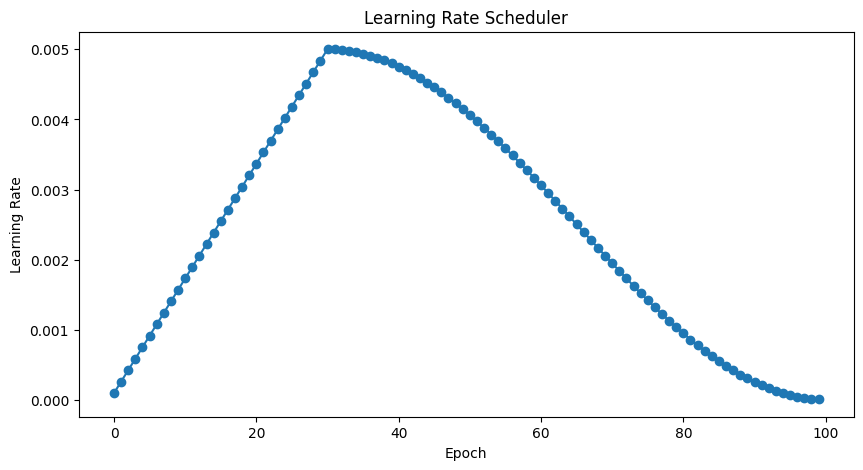


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - dir_acc: 0.5504 - loss: 1.1862
Epoch 1: dir_acc improved from -inf to 0.59325, saving model to transformer_train_model.keras

Epoch 1: val_dir_acc improved from -inf to 0.38410, saving model to transformer_val_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 482ms/step - dir_acc: 0.5540 - loss: 1.1560 - val_dir_acc: 0.3841 - val_loss: 0.3446 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00026333333333333336.
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - dir_acc: 0.6248 - loss: 0.2520
Epoch 2: dir_acc improved from 0.59325 to 0.63871, saving model to transformer_train_model.keras

Epoch 2: val_dir_acc improved from 0.38410 to 0.38469, saving model to transformer_val_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step - dir_acc: 0.6260 - loss: 0.2510 - val_dir_acc: 0.3847 - val_loss: 0.1764 - learning_rate: 2.6333e-04

Epoch 

In [10]:
BATCH_SIZE = 64
EPOCHS = 100
model.fit(X_train, y_train,
          validation_data=(X_dev, y_dev),
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=True,
          callbacks=[checkpoint_callback_train, checkpoint_callback_val, get_lr_callback(batch_size=BATCH_SIZE, epochs=EPOCHS, plot=True)])

In [11]:
# Load Weights
model.load_weights("transformer_val_model.keras")

# Make predictions
accuracy = model.evaluate(X_test, y_test)[1]
print(f"MODEL ACCURACY: {accuracy}")

# Calculate additional metrics as needed
from sklearn.metrics import r2_score

predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - dir_acc: 0.8045 - loss: 0.2444
MODEL ACCURACY: 0.818548321723938
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
R-squared: -1.252525518065858


R² score: -1.2525


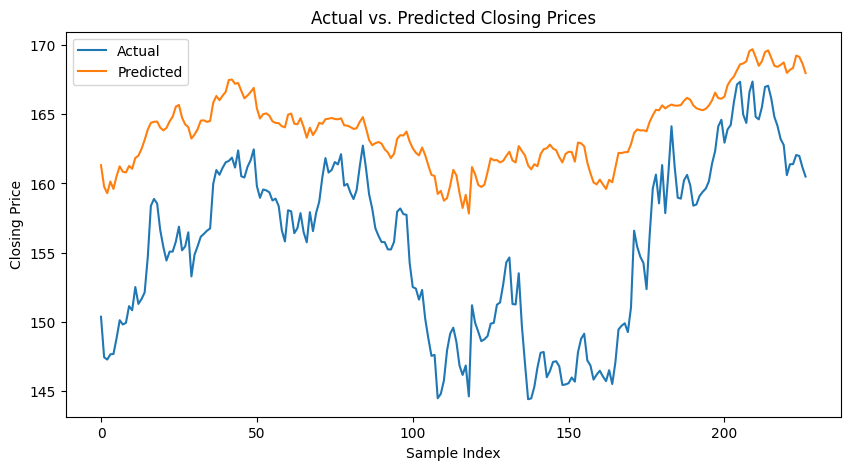

In [12]:
# -------------------------
# Evaluation
# -------------------------

# Inverse scale predictions and actuals
y_pred_inv = scaler_y.inverse_transform(predictions)
y_test_inv = scaler_y.inverse_transform(y_test)

r2 = r2_score(y_test_inv, y_pred_inv)
print(f"R² score: {r2:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Actual vs. Predicted Closing Prices')
plt.xlabel('Sample Index')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np


# Load the test file
try:
    jnj_x_test = pd.read_csv("../../data/input_data_splits/jnj_X_test.csv")
except FileNotFoundError:
    print("The file 'jnj_X_test.csv' was not found. Ensure the file is in the correct directory.")
    raise

# Ensure that the number of samples in y_pred_inv matches the length of the test file
# Take the last n samples from the test file where n is the length of y_pred_inv
n = len(y_pred_inv)
if n > len(jnj_x_test):
    raise ValueError("The number of predictions exceeds the rows in the test file.")

jnj_x_test_shrunk = jnj_x_test.iloc[-n:].copy()

# Ensure the date column exists
if 'Date' not in jnj_x_test_shrunk.columns:
    raise KeyError("The 'Date' column is not found in the test file. Ensure the file has a 'date' column.")

# Create a new DataFrame where the index is the 'date' column from the shrunk test file
# and the values are from y_pred_inv
output_df = pd.DataFrame({
    'Date': jnj_x_test_shrunk['Date'].values,
    'predicted_closing_price': y_pred_inv.flatten()  # Flatten if y_pred_inv is 2D
})

# Save the DataFrame to a CSV file
output_csv_path = "../../data/final_output_data/jnjTransformerpred.csv"
output_df.to_csv(output_csv_path, index=False)

print(f"The file was successfully saved to {output_csv_path}")


The file was successfully saved to ../../data/final_output_data/jnjTransofmerpred.csv
